<a href="https://colab.research.google.com/github/fin-ash/MAIR/blob/main/Final_Tp2_vietnam_war.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=decef3cb06714173d0ac4bbf46e1feb2c2e508916673c5014c5565330bd8422e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.6 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [2]:
"""Now, we authenticate a Google Drive client to download the file we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**
"""

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1L6pCQkldvdBoaEhRFzL0VnrggEFvqON4'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('Bombing_Operations.json.gz')

id='14dyBmcTBA32uXPxDbqr0bFDIzGxMTWwl'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('Aircraft_Glossary.json.gz')

In [3]:

"""If you executed the cells above, you should be able to see the files *Bombing_Operations.json.gz* and *Aircraft_Glossary.json.gz* under the "Files" tab on the left panel."""

# Commented out IPython magic to ensure Python compatibility.
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf


In [4]:

"""Let's initialize the Spark context.

"""

# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

"""You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**)."""

spark

"""# Vietnam War

----

The Vietnam War, also known as the Second Indochina War, and in Vietnam as the Resistance War Against America or simply the American War, was a conflict that occurred in Vietnam, Laos, and Cambodia from 1 November 1955 to the fall of Saigon on 30 April 1975. It was the second of the Indochina Wars and was officially fought between North Vietnam and the government of South Vietnam.

**The dataset describes all the air force operation in during the Vietnam War.**

**Bombing_Operations** [Get the dataset here](https://drive.google.com/a/epfl.ch/file/d/1L6pCQkldvdBoaEhRFzL0VnrggEFvqON4/view?usp=sharing)

- AirCraft: _Aircraft model
- ContryFlyingMission: _Country_
- MissionDate: _Date of the mission_
- OperationSupported: _Supported War operation_ (example: [Operation Rolling Thunder](https://en.wikipedia.org/wiki/Operation_Rolling_Thunder))
- PeriodOfDay: _Day or night_
- TakeoffLocation: _Take off airport_
- TimeOnTarget
- WeaponType
- WeaponsLoadedWeight

**Aircraft_Glossary** [Get the dataset here](https://drive.google.com/a/epfl.ch/file/d/14dyBmcTBA32uXPxDbqr0bFDIzGxMTWwl/view?usp=sharing)

- AirCraft: _Aircraft model
- AirCraftName
- AirCraftType

**Dataset Information:**

THOR is a painstakingly cultivated database of historic aerial bombings from World War I through Vietnam. THOR has already proven useful in finding unexploded ordnance in Southeast Asia and improving Air Force combat tactics:
https://www.kaggle.com/usaf/vietnam-war-bombing-operations

Load the datasets:
"""

Bombing_Operations = spark.read.json("Bombing_Operations.json.gz")
Aircraft_Glossary = spark.read.json("Aircraft_Glossary.json.gz")

"""Check the schema:"""

Bombing_Operations.printSchema()

Aircraft_Glossary.printSchema()

"""Get a sample with `take()`:"""

Bombing_Operations.take(3)

"""Get a formatted sample with `show()`:"""

Aircraft_Glossary.show()

print("In total there are {0} operations".format(Bombing_Operations.count()))


root
 |-- AirCraft: string (nullable = true)
 |-- ContryFlyingMission: string (nullable = true)
 |-- MissionDate: string (nullable = true)
 |-- OperationSupported: string (nullable = true)
 |-- PeriodOfDay: string (nullable = true)
 |-- TakeoffLocation: string (nullable = true)
 |-- TargetCountry: string (nullable = true)
 |-- TimeOnTarget: double (nullable = true)
 |-- WeaponType: string (nullable = true)
 |-- WeaponsLoadedWeight: long (nullable = true)

root
 |-- AirCraft: string (nullable = true)
 |-- AirCraftName: string (nullable = true)
 |-- AirCraftType: string (nullable = true)

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|    

+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|AirCraft| ContryFlyingMission|MissionDate|OperationSupported|PeriodOfDay|TakeoffLocation|TargetCountry|TimeOnTarget|          WeaponType|WeaponsLoadedWeight|
+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|   EC-47|UNITED STATES OF ...| 1971-06-05|              NULL|          D|   TAN SON NHUT|     CAMBODIA|      1005.0|                NULL|                  0|
|   EC-47|UNITED STATES OF ...| 1972-12-26|              NULL|          D|  NAKHON PHANOM|SOUTH VIETNAM|       530.0|                NULL|                  0|
|    RF-4|UNITED STATES OF ...| 1973-07-28|              NULL|          D|       UDORN AB|         LAOS|       730.0|                NULL|                  0|
|     A-1|UNITED STATES OF ...| 1970-02-02|   

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+--------------------+-------------+
| ContryFlyingMission|MissionsCount|
+--------------------+-------------+
|UNITED STATES OF ...|      3708997|
|     VIETNAM (SOUTH)|       622013|
|                LAOS|        32777|
|       KOREA (SOUTH)|        24469|
|           AUSTRALIA|        12519|
+--------------------+-------------+



Text(0.5, 1.0, 'Number of missions by Country')

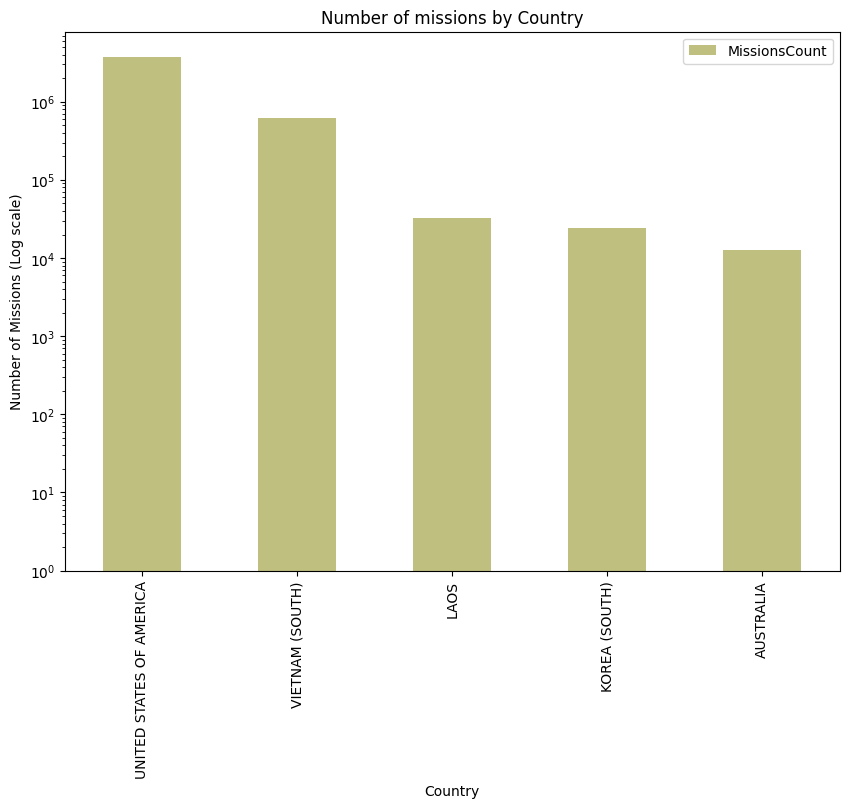

In [5]:

"""## Question 1: Which countries are involved and in how many missions?

Keywords: `Dataframe API`, `SQL`, `group by`, `sort`

Let's group the missions by `ContryFlyingMission` and count how many records exist:
"""

Bombing_Operations.show()

tmp1 = Bombing_Operations.groupBy("ContryFlyingMission").count().sort(desc("count"))
tmp1.show()

missions_counts = Bombing_Operations.groupBy("ContryFlyingMission")\
                                    .agg(count("*").alias("MissionsCount"))\
                                    .sort(desc("MissionsCount"))
missions_counts.show()

"""In this case we used the DataFrame API, but we could rewite the `groupBy` using pure SQL:"""

Bombing_Operations.registerTempTable("Bombing_Operations")

query = """
SELECT ContryFlyingMission, count(*) as MissionsCount
FROM Bombing_Operations
GROUP BY ContryFlyingMission
ORDER BY MissionsCount DESC
"""

missions_counts = spark.sql(query)
missions_counts.show()

"""The Dataframe is small enough to be moved to Pandas:"""

missions_count_pd = missions_counts.toPandas()
missions_count_pd.head()

"""Let's plot a barchart with the number of missions by country:"""

pl = missions_count_pd.plot(kind="bar",
                            x="ContryFlyingMission", y="MissionsCount",
                            figsize=(10, 7), log=True, alpha=0.5, color="olive")
pl.set_xlabel("Country")
pl.set_ylabel("Number of Missions (Log scale)")
pl.set_title("Number of missions by Country")


'We can observe how South Vietnam increased its missions starting from 1970. The drop in 1973 is motivated by the [Paris Peace Accords](https://en.wikipedia.org/wiki/Paris_Peace_Accords) that took place on January 27th, 1973, to establish peace in Vietnam and end the war.\n'

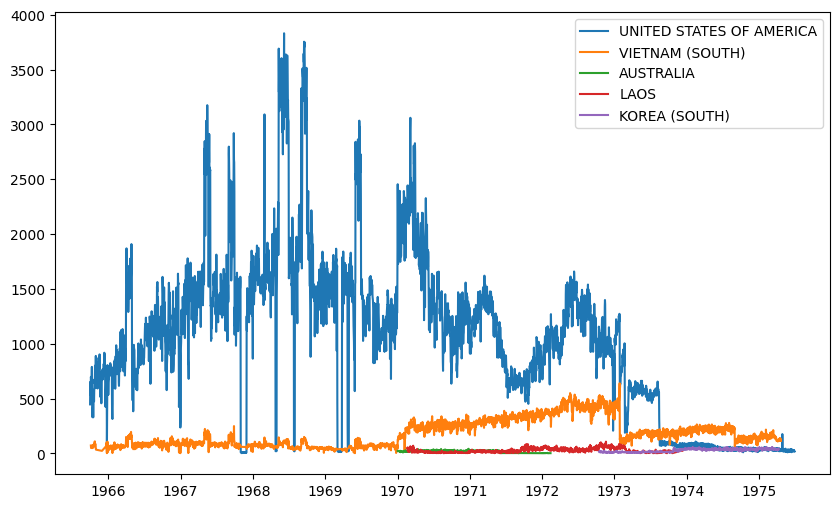

In [13]:
"""
## Questions 2: Show the number of missions in time for each of the countries involved.

Keywords: `group by`, `parse date`, `plot`

Let's select the relevant columns:
"""
missions_by_date = missions_countries\
                    .groupBy(["MissionDate", "ContryFlyingMission"])\
                    .agg(count("*").alias("MissionsCount"))\
                    .sort(asc("MissionDate"))

# Convert to Pandas DataFrame
missions_by_date_pd = missions_by_date.toPandas()

fig = plt.figure(figsize=(10, 6))

# Now you can iterate over the unique countries in the Pandas DataFrame
for country in missions_by_date_pd['ContryFlyingMission'].unique():
    # For each country, create a new DataFrame containing only the rows for that country
    missions = missions_by_date_pd[missions_by_date_pd['ContryFlyingMission'] == country]
    plt.plot(missions["MissionDate"], missions["MissionsCount"], label=country)

plt.legend(loc='best')


"""We can observe how South Vietnam increased its missions starting from 1970. The drop in 1973 is motivated by the [Paris Peace Accords](https://en.wikipedia.org/wiki/Paris_Peace_Accords) that took place on January 27th, 1973, to establish peace in Vietnam and end the war.
"""

In [16]:
"""We can observe how South Vietnam increased its missions starting from 1970. The drop in 1973 is motivated by the [Paris Peace Accords](https://en.wikipedia.org/wiki/Paris_Peace_Accords) that took place on January 27th, 1973, to establish peace in Vietnam and end the war.

----
## Question 3: Who bombed this location?

Keywords: `RDD map reduce` `cache` `save results`

This picture is the Hanoi POL facility (North Vietnam) burning after it was attacked by the U.S. Air Force on 29 June 1966 in the context of the Rolling Thunder operation.

We are interested in discovering what was the most common take-off location during that day.
"""

jun_29_operations = Bombing_Operations.where("MissionDate = '1966-06-29' AND TargetCountry='NORTH VIETNAM'")
jun_29_operations.show()

"""Which coutries scheduled missions that day?"""

jun_29_operations.groupBy("ContryFlyingMission").agg(count("*").alias("MissionsCount")).toPandas()

"""Most of the operation that day were performed by USA airplanes."""

jun_29_operations.take(1)

"""You can specify to cache the content in memory:"""

jun_29_operations.cache()

"""Now you can count the number of rows and move the content to the cache:"""

# Commented out IPython magic to ensure Python compatibility.
# %time jun_29_operations.count()

"""The second time the content is cached and the operation is much faster:"""

# Commented out IPython magic to ensure Python compatibility.
# %time jun_29_operations.count()

"""You can also save the results on a file..."""

jun_29_operations.write.mode('overwrite').json("jun_29_operations.json")

"""... and read from the file:"""

jun_29_operations = spark.read.json("jun_29_operations.json")

"""We can use the simple DataFrame API..."""

TakeoffLocationCounts = jun_29_operations\
                            .groupBy("TakeoffLocation").agg(count("*").alias("MissionsCount"))\
                            .sort(desc("MissionsCount"))
TakeoffLocationCounts.show()

"""... or the explicit Map/Reduce format with RDDs.

First we emit a pair in the format (Location, 1):
"""

all_locations = jun_29_operations.rdd.map(lambda row: (row.TakeoffLocation, 1))
all_locations.take(3)

"""Then, we sum counters in the reduce step, and we sort by count:"""

locations_counts_rdd = all_locations.reduceByKey(lambda a, b: a+b).sortBy(lambda r: -r[1])
locations_counts_rdd.take(3)

"""Now we can convert the RDD in dataframe by mapping the pairs to objects of type `Row`"""

locations_counts_with_schema = locations_counts_rdd.map(lambda r: Row(TakeoffLocation=r[0], MissionsCount=r[1]))
locations_counts = spark.createDataFrame(locations_counts_with_schema)
locations_counts.show()


+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------+-------------------+
|AirCraft| ContryFlyingMission|MissionDate|OperationSupported|PeriodOfDay|TakeoffLocation|TargetCountry|TimeOnTarget|    WeaponType|WeaponsLoadedWeight|
+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------+-------------------+
|   F-105|UNITED STATES OF ...| 1966-06-29|       STEEL TIGER|          D|         TAKHLI|NORTH VIETNAM|       310.0|  1000LB MK-83|                 -1|
|   C-130|UNITED STATES OF ...| 1966-06-29|      ROLLING THUN|          N|         DANANG|NORTH VIETNAM|      1226.0|          NULL|                 -1|
|     F-4|UNITED STATES OF ...| 1966-06-29|      ROLLING THUN|          D|  CONSTELLATION|NORTH VIETNAM|       703.0| 2.75IN HE RKT|                 -1|
|   C-130|UNITED STATES OF ...| 1966-06-29|      ROLLING THUN|          N|        

In [20]:
"""
That day the most common take-off location was the ship USS Constellation (CV-64). We cannot univocally identify one take off location, but we can reduce the possible candidates. Next steps: explore TimeOnTarget feature.

_USS Constellation (CV-64), a Kitty Hawk-class supercarrier, was the third ship of the United States Navy to be named in honor of the "new constellation of stars" on the flag of the United States. One of the fastest ships in the Navy, as proven by her victory during a battlegroup race held in 1985, she was nicknamed "Connie" by her crew and officially as "America's Flagship"._

----

## Questions 4: What is the most used aircraft type during the Vietnam war (number of missions)?

Keywords: `join` `group by`

Let's check the content of `Aircraft_Glossary`:
"""

Aircraft_Glossary.show(5)

"""We are interested in the filed `AirCraftType`."""

Bombing_Operations.select("AirCraft").show(5)

"""We can join on the column `AirCraft` of both dataframes.

With Dataframe API:
"""

missions_joined = Bombing_Operations.join(Aircraft_Glossary,
                                          Bombing_Operations.AirCraft == Aircraft_Glossary.AirCraft)
missions_joined

"""We can select only the field we are interested in:"""

missions_aircrafts = missions_joined.select("AirCraftType")
missions_aircrafts.show(5)

"""And finally we can group by `AirCraftType` and count:"""

missions_aircrafts.groupBy("AirCraftType").agg(count("*").alias("MissionsCount"))\
                  .sort(desc("MissionsCount"))\
                  .show()

"""In alternative we can rewrite this in pure SQL:"""

Bombing_Operations.registerTempTable("Bombing_Operations")
Aircraft_Glossary.registerTempTable("Aircraft_Glossary")

query = """
SELECT AirCraftType, count(*) MissionsCount
FROM Bombing_Operations bo
JOIN Aircraft_Glossary ag
ON bo.AirCraft = ag.AirCraft
GROUP BY AirCraftType
ORDER BY MissionsCount DESC
"""

spark.sql(query).show()

"""The aircrafts of type `Fighter Jet Bomber` participated in most of the missions in the Vietnam war.

Note: This dataset would require further cleaning and normalization. See `Fighter Jet Bomber`, `Jet Fighter Bomber`, `Fighter bomber jet`
"""

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
+--------+--------------------+--------------------+
only showing top 5 rows

+--------+
|AirCraft|
+--------+
|   EC-47|
|   EC-47|
|    RF-4|
|     A-1|
|    A-37|
+--------+
only showing top 5 rows

+--------------------+
|        AirCraftType|
+--------------------+
|Military Transpor...|
|Military Transpor...|
|  Fighter bomber jet|
|         Fighter Jet|
|Light ground-atta...|
+--------------------+
only showing top 5 rows

+--------------------+-------------+
|        AirCraftType|MissionsCount|
+--------------------+-------------+
|  Fighter Jet Bomber|      107

'The aircrafts of type `Fighter Jet Bomber` participated in most of the missions in the Vietnam war.\n\nNote: This dataset would require further cleaning and normalization. See `Fighter Jet Bomber`, `Jet Fighter Bomber`, `Fighter bomber jet`\n'

In [28]:
from pyspark.sql.functions import when, col

# Define a list of aircraft type names that need to be normalized
aircraft_types = ["Fighter Jet Bomber", "Jet Fighter Bomber", "Fighter bomber jet"]

# Normalize the aircraft type names in the Aircraft_Glossary DataFrame
Aircraft_Glossary_normalized = Aircraft_Glossary.withColumn(
    "AirCraftType",
    when(col("AirCraftType").isin(aircraft_types), "Fighter Jet Bomber").otherwise(col("AirCraftType"))
)

# Join the Bombing_Operations and Aircraft_Glossary_normalized DataFrames
missions_joined = Bombing_Operations.join(
    Aircraft_Glossary_normalized,
    Bombing_Operations.AirCraft == Aircraft_Glossary_normalized.AirCraft
)

# Group by AirCraftType and count the number of missions
missions_aircrafts = missions_joined.groupBy("AirCraftType").agg(count("*").alias("MissionsCount"))

# Sort by MissionsCount in descending order and show the result
missions_aircrafts.sort(desc("MissionsCount")).show()


+--------------------+-------------+
|        AirCraftType|MissionsCount|
+--------------------+-------------+
|  Fighter Jet Bomber|      1766742|
|         Fighter Jet|       882594|
|     Attack Aircraft|       315246|
|Light ground-atta...|       267457|
|Military Transpor...|       228426|
|  Utility Helicopter|       146653|
|    Strategic bomber|        99100|
|     Tactical Bomber|        82219|
|Observation Aircraft|        81820|
|Fixed wing ground...|        75058|
|Ground attack air...|        73843|
|Carrier-based Fig...|        58691|
|   Training Aircraft|        48435|
|       Light fighter|        39999|
|        Light Bomber|        39262|
|Light Tactical Bo...|        34738|
| Light Utility Plane|        28582|
|Observation/ Ligh...|        24491|
|Airborne early wa...|        17226|
|   Rescue Helicopter|        10331|
+--------------------+-------------+
only showing top 20 rows



In [25]:
query = """
SELECT bo.ContryFlyingMission, ag.AirCraftType, COUNT(*) as MissionsCount
FROM Bombing_Operations bo
JOIN Aircraft_Glossary ag
ON bo.AirCraft = ag.AirCraft
GROUP BY bo.ContryFlyingMission, ag.AirCraftType
ORDER BY MissionsCount DESC
"""
result = spark.sql(query)
result.show()


+--------------------+--------------------+-------------+
| ContryFlyingMission|        AirCraftType|MissionsCount|
+--------------------+--------------------+-------------+
|UNITED STATES OF ...|  Fighter Jet Bomber|      1073118|
|UNITED STATES OF ...|         Fighter Jet|       726477|
|UNITED STATES OF ...|  Jet Fighter Bomber|       451379|
|UNITED STATES OF ...|     Attack Aircraft|       315246|
|UNITED STATES OF ...|  Fighter bomber jet|       242231|
|UNITED STATES OF ...|Military Transpor...|       181707|
|     VIETNAM (SOUTH)|         Fighter Jet|       154120|
|     VIETNAM (SOUTH)|Light ground-atta...|       140968|
|     VIETNAM (SOUTH)|  Utility Helicopter|       139620|
|UNITED STATES OF ...|Light ground-atta...|       126489|
|UNITED STATES OF ...|    Strategic bomber|        99100|
|UNITED STATES OF ...|Fixed wing ground...|        75058|
|UNITED STATES OF ...|     Tactical Bomber|        71697|
|UNITED STATES OF ...|Carrier-based Fig...|        58691|
|UNITED STATES

In [26]:
query = """
SELECT ContryFlyingMission, COUNT(*)/COUNT(DISTINCT MissionDate) as AvgMissionsPerDay
FROM Bombing_Operations
GROUP BY ContryFlyingMission
"""
result = spark.sql(query)
result.show()


+--------------------+------------------+
| ContryFlyingMission| AvgMissionsPerDay|
+--------------------+------------------+
|     VIETNAM (SOUTH)| 185.2331745086361|
|       KOREA (SOUTH)| 27.96457142857143|
|UNITED STATES OF ...| 1042.438729623384|
|           AUSTRALIA|16.237354085603112|
|                LAOS| 28.72655565293602|
+--------------------+------------------+



In [27]:
query = """
SELECT ag.AirCraftType, bo.TargetCountry, COUNT(*) as MissionsCount
FROM Bombing_Operations bo
JOIN Aircraft_Glossary ag
ON bo.AirCraft = ag.AirCraft
GROUP BY ag.AirCraftType, bo.TargetCountry
ORDER BY MissionsCount DESC
"""
result = spark.sql(query)
result.show()

+--------------------+-------------+-------------+
|        AirCraftType|TargetCountry|MissionsCount|
+--------------------+-------------+-------------+
|         Fighter Jet|SOUTH VIETNAM|       442524|
|  Fighter Jet Bomber|         LAOS|       438819|
|  Jet Fighter Bomber|SOUTH VIETNAM|       414141|
|  Fighter Jet Bomber|SOUTH VIETNAM|       313326|
|  Fighter Jet Bomber|NORTH VIETNAM|       267342|
|Light ground-atta...|SOUTH VIETNAM|       234321|
|         Fighter Jet|         LAOS|       225377|
|         Fighter Jet|NORTH VIETNAM|       196199|
|  Utility Helicopter|SOUTH VIETNAM|       142816|
|Military Transpor...|SOUTH VIETNAM|       133096|
|     Attack Aircraft|         LAOS|       127226|
|  Fighter bomber jet|         LAOS|       117745|
|     Attack Aircraft|NORTH VIETNAM|       111721|
|Observation Aircraft|SOUTH VIETNAM|        72784|
|  Fighter bomber jet|SOUTH VIETNAM|        70749|
|     Attack Aircraft|SOUTH VIETNAM|        64615|
|Military Transpor...|         

In [29]:
query = """
SELECT TakeoffLocation, COUNT(*) as MissionsCount
FROM Bombing_Operations
GROUP BY TakeoffLocation
ORDER BY MissionsCount DESC
"""
result = spark.sql(query)
result.show()


+---------------+-------------+
|TakeoffLocation|MissionsCount|
+---------------+-------------+
|       BIEN HOA|       492324|
|         DANANG|       489942|
|        UBON AB|       348822|
|   TAN SON NHUT|       311872|
|       UDORN AB|       306556|
|        CHU LAI|       242096|
|      PHAN RANG|       240238|
|    TONKIN GULF|       194191|
|  NAKHON PHANOM|       194069|
|          KORAT|       191081|
|      BINH THUY|       144003|
|        TUY HOA|       122547|
|         PLEIKU|       110322|
|   CAM RANH BAY|        96373|
|        U TAPAO|        85041|
|           VTBI|        75873|
|         TAKHLI|        65435|
|      NHA TRANG|        56818|
|           VVPU|        53814|
|        PHU CAT|        50353|
+---------------+-------------+
only showing top 20 rows



In [30]:
query = """
SELECT bo.ContryFlyingMission AS BombingCountry, bo.TargetCountry, COUNT(*) as BombCount
FROM Bombing_Operations bo
GROUP BY bo.ContryFlyingMission, bo.TargetCountry
ORDER BY BombCount DESC
LIMIT 1
"""
result = spark.sql(query)
result.show()


+--------------------+-------------+---------+
|      BombingCountry|TargetCountry|BombCount|
+--------------------+-------------+---------+
|UNITED STATES OF ...|SOUTH VIETNAM|  1567441|
+--------------------+-------------+---------+

